# PyTracer Quick Start Guide

--------------



In this quick start tutorial, we use a simple
example to illustrate the basic work flow
of PyTracer. Concretely, we will render
a sphere (as a built-in `Sphere` object) and a
slab (as modeled by a triangle mesh) under the
illumination of a spherical diffuse area light.

Essentially, we will model the scene and camera
separately, hence the `Scene` object, after constructed.
can be reused with different configuration
of `Camera`. We shall thereafter initiate
the main rendering loop and PyTracer will
handle all the remaining work.

In [1]:
from __future__ import (absolute_import, print_function, division)
import numpy as np
import matplotlib.pyplot as plt
from pytracer import *
# from pytracer import Spectrum

# init spectrum (if applicable)
# must be first initialized if
# we use sampled texture/material,
# e.g., sampled BRDF or SPD texture
Spectrum.init()

plt.axis('off')

np.random.seed(1)

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Model Construction

### Transformations


`Transformation` objects are such that we use to specify
how the entities are placed in thw world. PyTracer uses
the left-handed coordinate system; each entity, including
`Shape`s and `Camera`s are build in their object coordinate system.
Different constructors
of `Transform` can be used including `rotate`, `translate`, `look_at`
and so on are defined for properly placing entities at convenience.

We will manually specify the placement of each entity
by way of `Transformation` in the sequel.

In [2]:
from pytracer.geometry import (Vector, Point)
from pytracer.transform import (Transform, AnimatedTransform)

### Geometric Primitive and Light Construction

We start by modeling a full sphere with radius $2$.
Materials or textures also need to be specified for rendering.
PyTracer has many build-in materials and textures. Generally,
each `Material` is constructed with several `Texture` parameters
specified. Each `Texture` can be constructed from a float scalar,
or a `Spectrum` type.
Measured `Texture` and `Material` are also supported, for example,
the measured BRDF or SPD texture.

Here we will use a simple `MatteMaterial` for the back slab; and
a `UberMaterial` for the `Sphere`.

Light source is also constructed at this stage, we build
a dufuse area light source by attaching a `Sphere` object
to it.

In [3]:
from pytracer.shape import (Sphere, create_triangle_mesh)
from pytracer.aggregate import GeometricPrimitive
from pytracer.light import DiffuseAreaLight
from pytracer.texture import ConstantTexture
from pytracer.material import (MatteMaterial, UberMaterial)

# slab
back_param = {
	'indices': [0, 1, 2, 2, 0, 3],
	'P': [-20, 0, -10,
          20, 0, -10,
          20, 9, -10,
          -20, 9, -10]
}
back_Kd = ConstantTexture(Spectrum([.1, .1, .1]))
back_sigma = ConstantTexture(0.)
back_mat = MatteMaterial(back_Kd, back_sigma)
back_trans = Transform.translate(Vector(0., -5., 0.))
back_shape = create_triangle_mesh(back_trans, back_trans.inverse(), False, back_param)
back = GeometricPrimitive(back_shape, back_mat)


# spheres
sphere_transform = Transform.translate(Vector(.5, .5, -6))
sphere_shape = Sphere(sphere_transform, sphere_transform.inverse(), False,  # whther reverse orientation
                      2., -2., 2., 360.)  # for partial sphere: radius, z_min, z_max, phi_max (in degrees)

# material
Kd = ConstantTexture(Spectrum([.25, .25, .25]))
Ks = ConstantTexture(Spectrum([.25, .25, .25]))
Kr = ConstantTexture(Spectrum([0., 0., 0.]))
Kt = ConstantTexture(Spectrum([.25, .25, .25]))
roughness = ConstantTexture(0.1)
opacity = ConstantTexture(Spectrum([1., 1., 1.]))
eta = ConstantTexture(1.5)
sphere_material = UberMaterial(Kd, Ks, Kr, Kt, roughness, opacity, eta)

sphere = GeometricPrimitive(sphere_shape, sphere_material)
shapes = [back, sphere]

light_transform = Transform.translate(Vector(0., 1., 5.))
light_shape = Sphere(light_transform, light_transform.inverse(), False, 1., -1., 1., 360.)
light = DiffuseAreaLight(light_transform, Spectrum(10.), 2, light_shape)

lights = [light]

### Aggregation and Acceleration Structure

Now we will make several encapsulations.
First we pack all `Shape`s in the scene into some acceleration structures,
here we select Bounding Volume Hierarchy (`BVH`) for fast ray-shape intersection
test, though we only have one two `Shape`s; next we encapsulate the aggregation
and lights to a `Scene` object. `Scene` objects are later passed to
some `Renderer` for rendereing. It is designed to be reusable.

In [4]:
from pytracer.scene import Scene
from pytracer.aggregate import BVH
aggs = BVH(shapes, False)
scene = Scene(aggs, lights, None)

## Camera Construction

### Camera and Sub-pixel Sampling


Next we will configure the `Camera` placement.
`Camera` are assumed to be movable, with movements interpolated
using quaternion interpolation; this functionality has not
been fully implemented though.
PyTracer supports projective, perspective and
orthographic cameras. Here we use a `ProjectiveCamera`.
Noted for multiplcation is overloaded for `Transform` for
cascading transformations.

Each `Camera` possesses a `Film` object responsible
for pixel updating and writing traced image to file. PyTracer
uses sub-pixel sampling, hence a `Filter` is needed for `Film`
to properly handle the interpolation.
Sub-pixel samples are generated by the `Sampler`, which internally
uses the `numpy` random generator.

In [5]:
from pytracer.camera import PerspectiveCamera
from pytracer.film import ImageFilm
from pytracer.filter import LanczosSincFilter
from pytracer.sampler import StratifiedSampler


# image resolution
x_res, y_res = 64, 64

# samples per pixel
x_spr, y_spr = 2, 2

# specify sampler
sampler = StratifiedSampler(0, x_res, 0, y_res, x_spr, y_spr, True, 0., 0.)

# specify placement for camera
trans = Transform.translate(Vector(3.5, 3.5, 1.)) * Transform.look_at(Point(0.1, 0., 0.), Point(0., 0., -1.), Vector(0., 0., 1.))
cam_trans = AnimatedTransform(trans, 0., trans, 0.)

# create film
# (xr, yr) is the image resolution in pixels
# if no file name specified, a temporary file
# `.tmp.png` is created
film = ImageFilm(xr=x_res, yr=y_res, filt=LanczosSincFilter(4., 4., 3.),
                 crop=[0., 1., 0., 1.], fn='tmp.png')

camera = PerspectiveCamera(cam_trans, scr_win=[0., 1., 0., 1.], s_open=0.,
                           s_close=0., lensr=0., focald=1e100, fov=90., f=film)

## Light Transport and Rendering Loop

Finally, we specify the sampler, integrators
and renderer being used.

In [6]:
from pytracer.integrator import DirectLightingIntegrator
from pytracer.renderer import SamplerRenderer

surface_integrator = DirectLightingIntegrator()
renderer = SamplerRenderer(sampler, camera, surface_integrator, None)  # VolumeIntegrator: coming soon

Hereafter we may enter the main rendering loop.
A progress bar is displayed for reporting the
current status. Images are *always* written on
completion, by default to `tmp.png`. A `numpy` array
of shape `x_res * y_res * 3` is also returned. Internally,
we use Pillow for image I/O.

In [7]:
image = renderer.render(scene)

Rendering |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


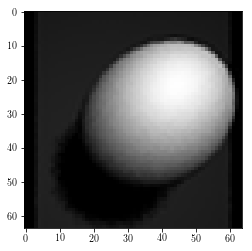

In [8]:
plt.imshow(image)

## Import Models

We may also direct `import` constructed models.
The saperation between `Scene` and `Camera` in
rendering enables reusing the `Scene` object
once loaded. We will next load the head mesh
model and trace it.

In [9]:
import examples.head_mesh as model

# construct camera with preferred configuration
camera = model.configure_camera(x_res=128, y_res=128)
sampler = StratifiedSampler(0, 128, 0, 128, 1, 1, True, 0., 0.)
surf_int = DirectLightingIntegrator()

renderer = SamplerRenderer(sampler, camera, surf_int, None)
image = renderer.render(model.scene)

Rendering |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


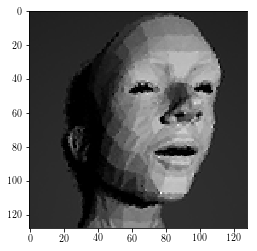

In [10]:
plt.imshow(image)